# EE 605 Digital Image Processing - Assignment 3: Image Filters

This assignment focuses on using the Wiener filter for image processing. We will work with images that have been affected by Gaussian noise and defocus blur. The main tasks include creating these effects on images, comparing our results with standard functions, and implementing the Wiener filter to fix these issues. Our goal is to learn how to enhance image quality using different filtering techniques.


## Importing Libraries

In [1]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
from PIL import Image
import matplotlib.pyplot as plt
from scipy.signal import gaussian, convolve2d
from numpy.fft import fft2, ifft2
from skimage.restoration import denoise_nl_means, denoise_tv_bregman
from skimage.filters import median
from skimage.filters import gaussian as gaussian_filter
from skimage import data, img_as_float

## Peak Signal-to-Noise Ratio (PSNR) in Image Processing

### Concept of PSNR:

Peak Signal-to-Noise Ratio (PSNR) is a widely used metric in image processing to assess the quality of a reconstructed or processed image in comparison to the original image. It's particularly valuable in areas like image compression and denoising.

### Calculation of PSNR:

PSNR is calculated based on the Mean Squared Error (MSE) between the original and the processed image. It is usually expressed in logarithmic decibel scale. The formula for PSNR is given by:

$\text{PSNR} = 20 \cdot \log_{10}(\text{MAX}_I) - 10 \cdot \log_{10}(\text{MSE})$

Here, $\text{MAX}_I$ represents the maximum possible pixel value of the image (e.g., 255 for an 8-bit grayscale image), and $\text{MSE}$ is the mean squared error between the original and processed images.

In [2]:
def mse(imageA, imageB):
    """
    Compute the Mean Squared Error (MSE) between two images.

    Parameters:
    imageA (numpy.ndarray): The first input image as a NumPy array.
    imageB (numpy.ndarray): The second input image as a NumPy array. It should
                           have the same dimensions as `imageA`.

    Returns:
    float: The Mean Squared Error between the two input images.
    """
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

def psnr_custom(imageA, imageB):
    """
    Compute the Peak Signal-to-Noise Ratio (PSNR) between two images.

    Parameters:
    imageA (numpy.ndarray): The first input image as a NumPy array.
    imageB (numpy.ndarray): The second input image as a NumPy array. It should
                           have the same dimensions as `imageA`.

    Returns:
    float: The PSNR value between the two input images.
    """
    mse_value = mse(imageA, imageB)
    if mse_value == 0:
        return 100  # Means the two images are identical
    MAX_I = 255.0
    return 20 * math.log10(MAX_I / math.sqrt(mse_value))


In [3]:

def gaussian_kernel(kernel_size = 11):
	h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
	h = np.dot(h, h.transpose())
	h /= np.sum(h)
	return h


In [4]:
def add_gaussian_noise_opencv(image, stddev):
    """
    Add Gaussian noise to an image.

    Parameters:
    image (numpy.ndarray): The input image as a NumPy array.
    stddev (float): The standard deviation of the Gaussian noise.

    Returns:
    numpy.ndarray: The noisy image.
    """
    noise = np.zeros_like(image)
    cv2.randn(noise, (0), (stddev))  # Create Gaussian noise
    noisy_image = cv2.add(image, noise)  # Add noise to the image
    return noisy_image

def apply_blur_opencv(image, blur_strength):
    """
    Apply Gaussian blur to an image.

    Parameters:
    image (numpy.ndarray): The input image as a NumPy array.
    blur_strength (int): The strength of the Gaussian blur.

    Returns:
    numpy.ndarray: The blurred image.
    """
    kernel_size = (blur_strength * 2 + 1, blur_strength * 2 + 1)  # Kernel size should be odd
    blurred_image = cv2.GaussianBlur(image, kernel_size, 0)
    return blurred_image

In [5]:
def wiener_filter(img, kernel, K):
    kernel /= np.sum(kernel)
    dummy = np.copy(img)
    dummy = fft2(dummy)
    kernel = fft2(kernel, s=img.shape)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.abs(ifft2(dummy))
    dummy = np.clip(dummy, 0, 255).astype(np.uint8)
    return dummy

Processing image: 1


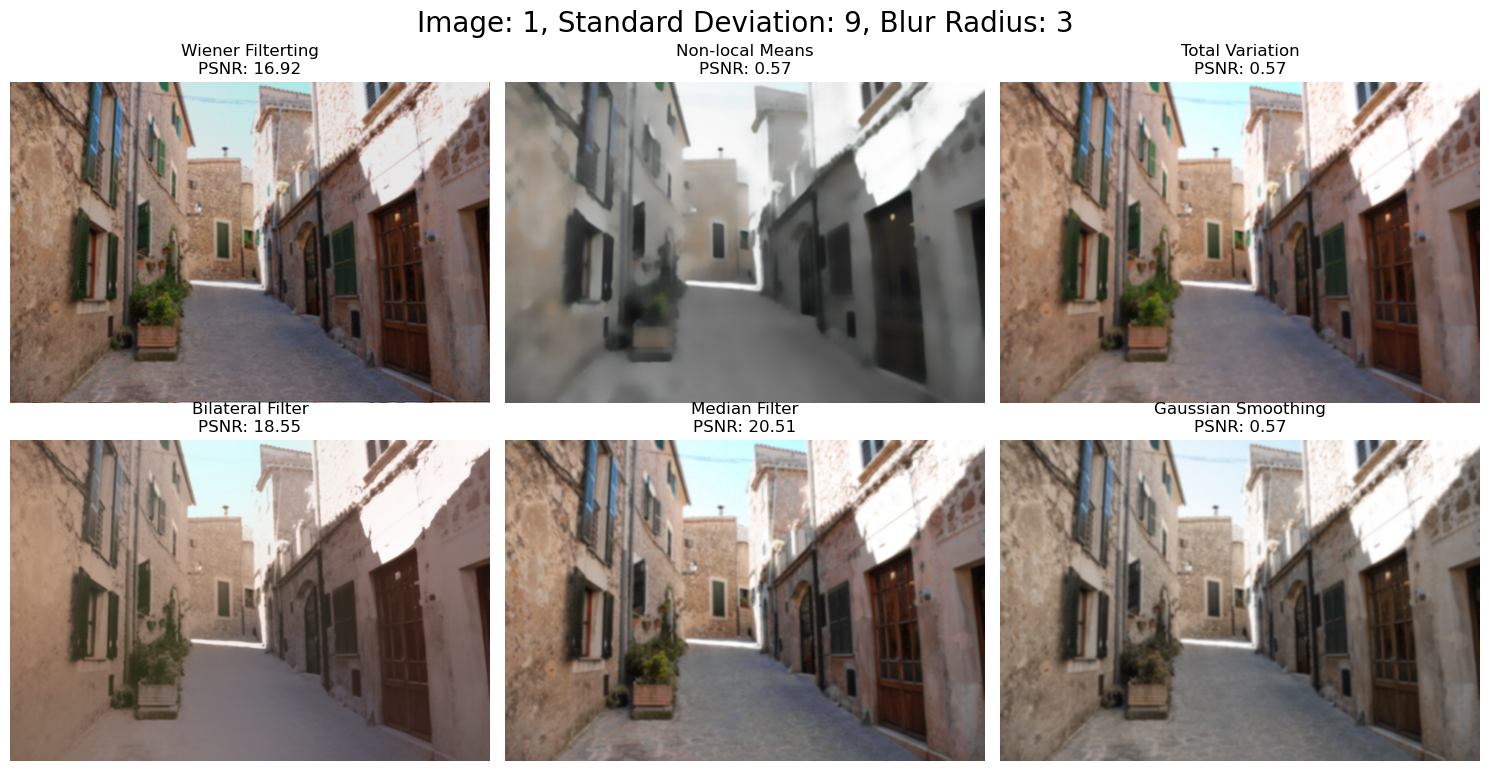

Processing image: 2


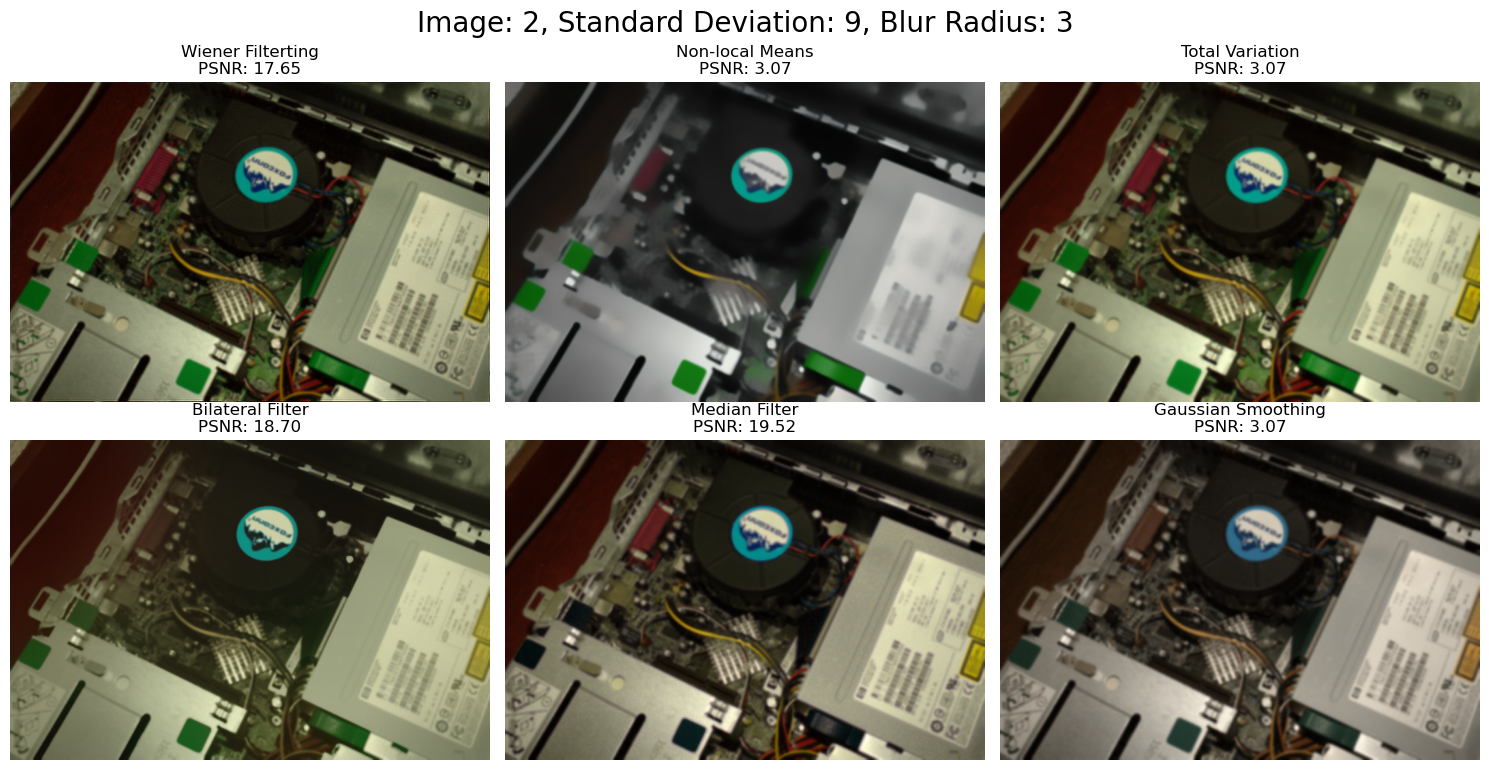

Processing image: 3


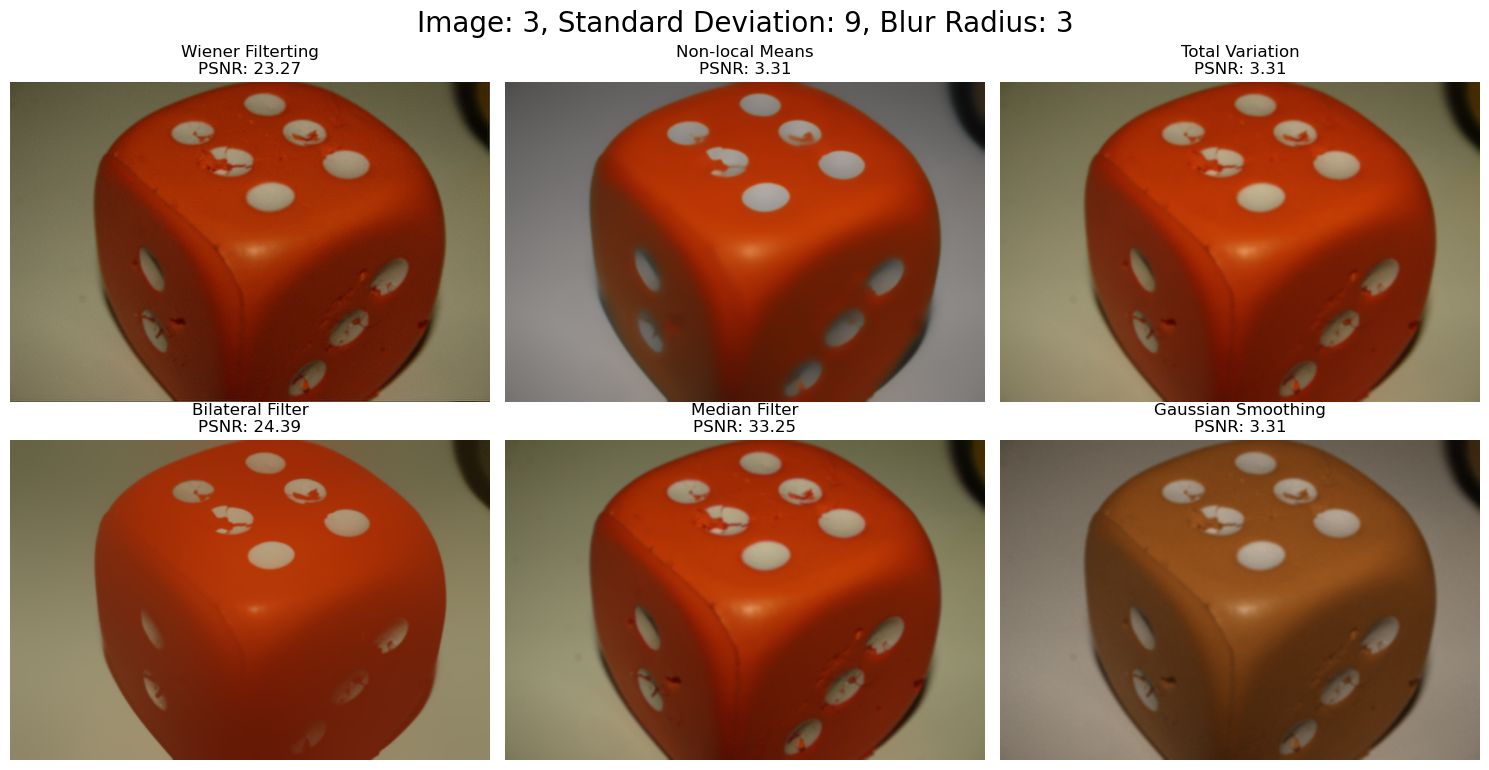

Processing image: 4


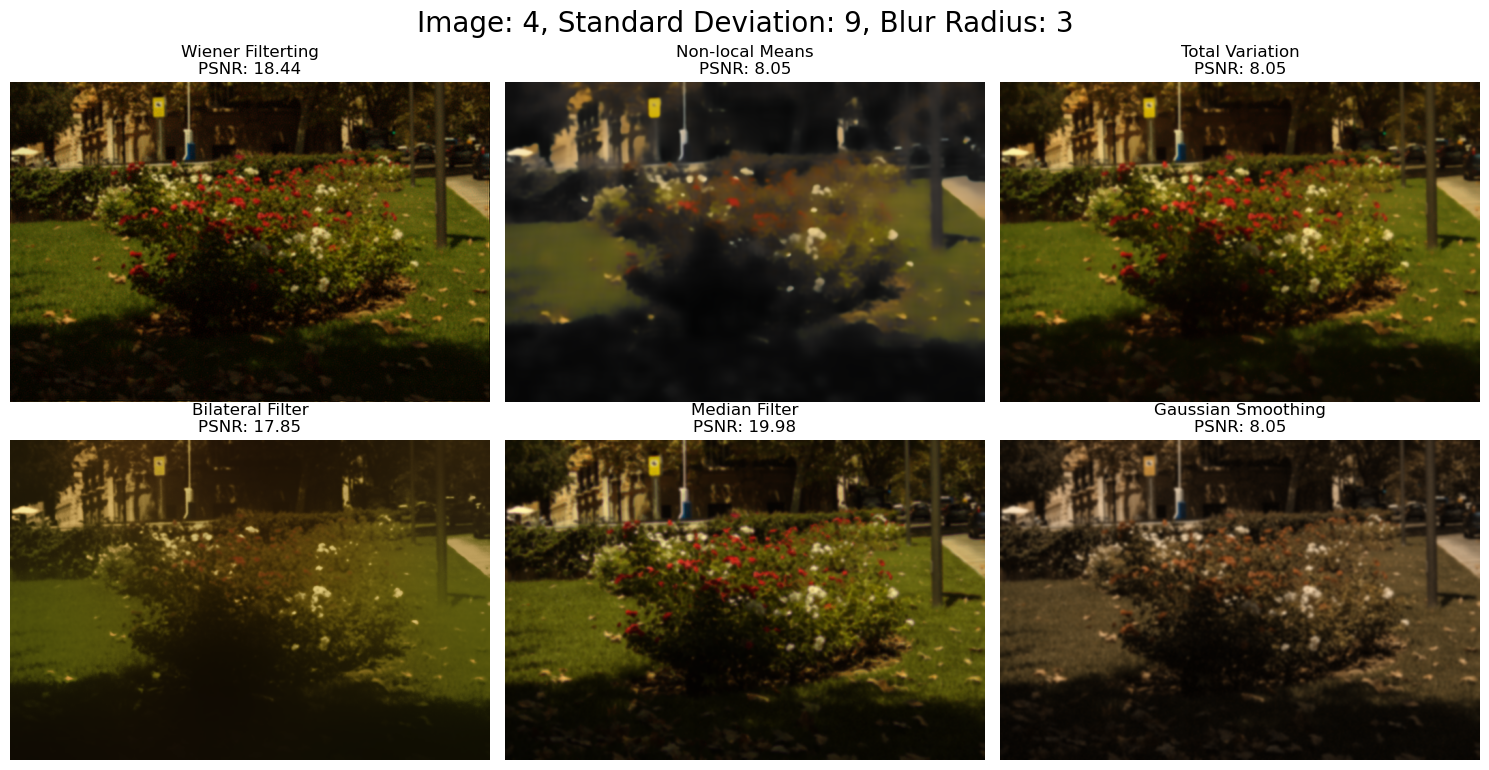

In [6]:
def comparison(image_paths, stddev, blur_strength):
    i = 0
    for path in image_paths:
        i += 1
        print(f'Processing image: {i}')
        # Load image in RGB
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply Gaussian noise and defocus blur
        blurred_image = apply_blur_opencv(image, blur_strength)
        noisy_image = add_gaussian_noise_opencv(blurred_image, stddev)
        kernel = gaussian_kernel(blur_strength)
        # filtered_img = wiener_filter(blurred_image, kernel, K = 10)

        restored_image_r_new = wiener_filter(noisy_image[:,:,0], kernel, K=.1)
        restored_image_g_new = wiener_filter(noisy_image[:,:,1], kernel, K=.1)
        restored_image_b_new = wiener_filter(noisy_image[:,:,2], kernel, K=.1)

        # Combine channels back into one image
        restored_image_new = np.stack((restored_image_r_new, restored_image_g_new, restored_image_b_new), axis=-1)
        # Apply Non-local Means Denoising
        nlm_denoised_image = denoise_nl_means(noisy_image, fast_mode=True)

        # Apply Total Variation Denoising
        tv_denoised_image = denoise_tv_bregman(noisy_image, weight=30)

        # Apply Bilateral Filter
        bilateral_denoised_image = cv2.bilateralFilter(noisy_image, -1, sigmaColor=75, sigmaSpace=75)

        # Apply Median Filter
        median_denoised_image = median(noisy_image)

        # Apply Gaussian Smoothing Filter
        gaussian_denoised_image = gaussian_filter(noisy_image, sigma=1)

        # Calculate PSNR values
        psnr_nlm = psnr_custom(image, nlm_denoised_image)
        psnr_tv = psnr_custom(image, tv_denoised_image)
        psnr_bilateral = psnr_custom(image, bilateral_denoised_image)
        psnr_median = psnr_custom(image, median_denoised_image)
        psnr_gaussian = psnr_custom(image, gaussian_denoised_image)
        psnr_wiener = psnr_custom(image, restored_image_new)
        # Display each processed image with rounded scores
        plt.figure(figsize=(15, 8))

        plt.subplot(231), plt.imshow(restored_image_new), plt.title('Wiener Filterting\nPSNR: {:.2f}'.format(psnr_wiener)), plt.axis('off')
        plt.subplot(232), plt.imshow(nlm_denoised_image), plt.title('Non-local Means\nPSNR: {:.2f}'.format(psnr_nlm)), plt.axis('off')
        plt.subplot(233), plt.imshow(tv_denoised_image), plt.title('Total Variation\nPSNR: {:.2f}'.format(psnr_tv)), plt.axis('off')
        plt.subplot(234), plt.imshow(bilateral_denoised_image), plt.title('Bilateral Filter\nPSNR: {:.2f}'.format(psnr_bilateral)), plt.axis('off')
        plt.subplot(235), plt.imshow(median_denoised_image), plt.title('Median Filter\nPSNR: {:.2f}'.format(psnr_median)), plt.axis('off')
        plt.subplot(236), plt.imshow(gaussian_denoised_image), plt.title('Gaussian Smoothing\nPSNR: {:.2f}'.format(psnr_gaussian)), plt.axis('off')

        plt.suptitle(f'Image: {i}, Standard Deviation: {stddev}, Blur Radius: {blur_strength}', fontsize=20)

        plt.tight_layout()
        plt.show()

image_paths = [
    '/Users/mihiragarwal/Desktop/Project Courses/Assignment - 3/Dataset/image1.png',
    '/Users/mihiragarwal/Desktop/Project Courses/Assignment - 3/Dataset/image2.png',
    '/Users/mihiragarwal/Desktop/Project Courses/Assignment - 3/Dataset/image3.png',
    '/Users/mihiragarwal/Desktop/Project Courses/Assignment - 3/Dataset/input4.png',
]


# Process all images

for pair in [(9,3)]:
        stddev, blur_strength = pair[0], pair[1]
        processed_images = comparison(image_paths, stddev, blur_strength)
        break
        